# KMEANS

## Objetivo de esta lección

Aprender a usar el que es el algoritmo no supervisado aplicado más frecuentemente en entornos empresariales: kmeans (kmedias).

## FICHA DEL ALGORITMO

### Ámbito de aplicación

Kmeans se usa en contextos no supervisados. Por ejemplo en los siguientes casos de uso:

* Segmentaciones: de clientes, proveedores, tiendas, ...
* Agrupaciones: textos, incidencias, zonas geográficas, tipos de crimen, ...
* Localización de atípicos multidimensionales: identificación de fraude, accesos sospechosos a sistemas, ...

Sklearn lo implementa con la clase KMeans() del módulo cluster.

### Pros

* Algoritmo sencillo
* Alta explicabilidad
* Solo 1 hiperparámetro: k

### Contras

* Hay que definir el número de segmentos por adelantado
* Como se basa en distancias necesita escalar las variables
* Sensible a multicolinealidad
* Sensible a la maldición de la dimensionalidad
* Las variebles categóricas pueden ser problemáticas
* Puede ser computacionalmente intenso en datasets grandes

### Necesidad de preprocesamiento

Eliminar variables correlacionadas para no sobreponderar conceptos.

Hacer encoding de las variables categóricas.

Escalar las variables.

### Supuestos e hipótesis

La distancia es una buena medida para identificar semejanza.

### Sobre ajuste

El algoritmo kmedias comienza con una selección aleatoria de las semillas.

Lo cual puede hacer que desarrollemos una solución no estable.

La implementación de Sklearn tiene opciones para reducir este problema:

* Un modo inteligente, llamado k-means++, para inicializar las semillas
* El parámetro n_init, que repetirá el proceso n veces con diferentes semillas y se quedará con la más estable (definida como la que tenga menor inercia (suma de cuadrados del error))

### Grado de interpretación

Alto.

Tras las salida del modelo se pueden cruzar los segmentos con otras variables para caracterizar cada uno de ellos.

Aunque la interpretación de qué es cada segmento siempre va a depender mucho del analista.

### Importación

In [34]:
from sklearn.cluster import KMeans

### Principales parámetros

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

* n_clusters: el número de clusters que queremos que obtenga
* n_init: número de repeticiones a realizar

### Principales atributos de resultado

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

* labels_: la etiqueta del segmento identificado para cada registro
* inertia_: la suma del cuadrado de los errores
* cluster_centers_: los centroides de cada cluster

### Principales métodos

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

* fit(): para entrenar
* predict(): para generar el segmento de cada registro
* get_params(): para extraer los parámetros del modelo entrenado

### Cómo elegir el número k

La mayor dificultad al entrenar un kmedias es elegir el número de segmentos, que es algo que le tenemos que decir al algoritmo.

Pero como no hay forma de saber de antemano el valor óptimo lo que se hace es ejecutar varias opciones que tendrían sentido desde negocio y evaluar el resultado con una serie de métodos:

**Método del codo (elbow method)** 

Consiste en calcular la media de la suma de cuadrados de los errores en cada cluster (nos lo da el atributo inertia_) y crear un gráfico con el resultado para cada valor de K. Entonces hay que buscar en qué momento se producte un salto (forma de codo) en el decremento de ese error.

**Método de la silueta (silhouette method)**

Es una fórmula que compara la distancia media de cada registro con el resto de registros de su cluster con la distancia media de ese registro a los otros registros del cluster más cercano. 

Por tanto a diferencia del método del codo que solo tenía en cuenta cuanto de cerca están los registros este método también añade cuanto de lejos están del resto.

Sklearn lo implementa en la función silhouette_score del módulo metrics, que nos devuelte un número que:

* Está entre -1 y 1
* Cuanto más cerca de 1 significa mejor solución
* Si está sobre cero significa que ya hay clusters que se solapan
* Si es negativo significa que los registros están siendo asignados a clusters incorrectos o que hay grandes outliers que están desvirtuando los resultados

**Índice Calinski-Harabasz**

Es el ratio entre la dispersión inter-cluster y la dispersión intra-cluster.

Sklearn lo implementa en la función calinski_harabasz_score del módulo metrics.

Cuanto mayor sea significa mejor segmentación.


**Índice Davies-Bouldin**

Es la similaridad media entre cada cluster y su otro cluster más cercano.

Sklearn lo implementa en la función davies_bouldin_score del módulo metrics.

Va de cero a infinito, siendo mejor segmentación cuanto más cercano a cero.

## EJEMPLO

### Opciones y paquetes

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Automcompletar rápido
%config IPCompleter.greedy=True

### Importación de datos

Vamos a usar el dataset sintético de target binaria.

In [36]:
#Cargamos el dataset sintetico_cluster.csv que está en 00_DATASETS
x = pd.read_csv('../00_DATASETS/sintetico_cluster.csv')
x

,x1,x2
0,6.182284,-4.216219
1,-3.397139,5.583268
2,-1.084075,5.518597
3,-3.955928,6.235456
4,4.910375,-4.695720
...,...,...
995,-0.867601,5.712312
996,-4.367363,5.689197
997,-4.947908,6.063362
998,-3.955862,7.082070


Lo visualizamos para hacernos una idea (esto es posible solo porque son 2 dimensiones, en la realidad no podremos hacerlo)

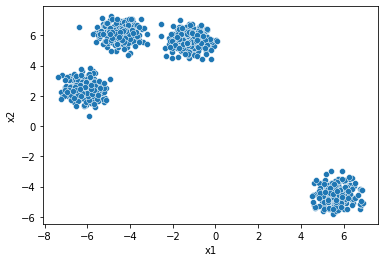

In [37]:
import seaborn as sns

sns.scatterplot(data = x, x = 'x1', y = 'x2');

### Modelo

#### Entrenar el modelo

Vamos a poner que desde negocio pensamos que podría tener sentido una solución desde 3 clusters hasta 6 clusters.

Por tanto vamos a crear un bucle donde vaya probando las soluciones con 3,4,5 y 6 clusters.

Y recolectando en cada solución las métricas que ya hemos descrito.

Además, para estar más tranquilos de que obtener una solución más estable, vamos a hacer que repita 10 veces cada proceso.

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

#Creamos el espacio de soluciones
soluciones = list(range(3,7))

#Creamos varias listas para ir guardando la salida de cada métrica
codo = []
silueta = []
calins = []
davies = []

#Probamos las diferentes soluciones
for solucion in soluciones:
    
    #Instanciar
    cluster = KMeans(random_state=1234, n_clusters = solucion, n_init=10)
    
    #Entrenar
    cluster.fit(x)
    
    #Recoger las métricas
    codo.append(cluster.inertia_)
    silueta.append(silhouette_score(x, cluster.labels_))
    calins.append(calinski_harabasz_score(x, cluster.labels_))
    davies.append(davies_bouldin_score(x, cluster.labels_))

Creamos un data frame con todas las métricas

In [39]:
metricas = pd.DataFrame({'Solucion':soluciones,
              'Codo': codo,
              'Silueta':silueta,
              'Calins':calins,           
              'Davies':davies}).set_index('Solucion')

metricas

,Codo,Silueta,Calins,Davies
Solucion,,,,
3,1850.917011,0.720026,10004.833381,0.381386
4,481.220958,0.796453,26573.587847,0.284044
5,436.071335,0.648266,21997.744056,0.669279
6,394.490807,0.538788,19454.180678,0.900558


Visualizamos los gráficos

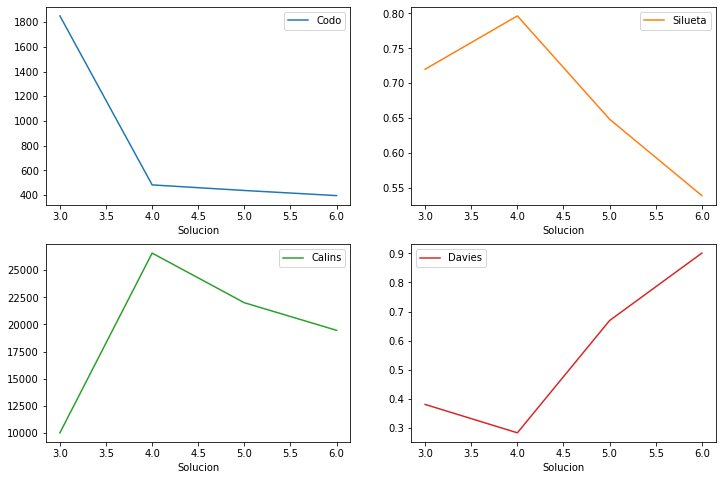

In [40]:
metricas.plot(subplots = True, figsize = (12,8), layout = (2,2), sharex = False);

Parece claro que la mejor solución es con 4 segmentos.

Así que vamos a crear el modelo final y escribir el segmento de cada registro en nuestro dataset.

#### Predecir

In [41]:
#Instanciar
cluster = KMeans(random_state=1234, n_clusters = 4, n_init=10)
    
#Entrenar
cluster.fit(x)

#Asignar segmento
x['cluster'] = cluster.predict(x)

x.head()

,x1,x2,cluster
0,6.182284,-4.216219,1
1,-3.397139,5.583268,0
2,-1.084075,5.518597,3
3,-3.955928,6.235456,0
4,4.910375,-4.695720,1


#### Visualización gráfica

En este caso como solo tenemos dos variables podemos representar los segmentos en un gráfico, asignar un color distinto a cada cluster y visualizarlo.

En la realidad haremos segmentaciones con muchas variables, por lo que no podremos hacer esto.

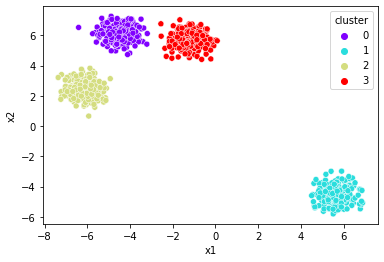

In [42]:
sns.scatterplot(data = x, x = 'x1', y = 'x2', hue = 'cluster', palette= 'rainbow');

#### Perfilado de los segmentos

Como habíamos dicho en una situación real no podremos visualizar los segmentos ya que tendremos muchas variables.

Pero lo que sí podemos hacer es calcular la media de cada variable en cada segmento y usarlo para ponerles "cara y ojos" a cada uno.

In [43]:
perfilado = x.groupby('cluster').mean()
perfilado

,x1,x2
cluster,,
0,-4.491661,6.132460
1,5.617912,-4.537224
2,-6.143397,2.431109
3,-1.212272,5.681711


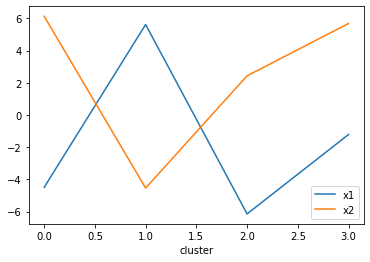

In [44]:
perfilado.plot();

## MINI BATCH KMEANS

Como decíamos al principio Kmeans puede ser computacionalmente intenso sobre muchos datos.

Y más si usamos n_init y probamos soluciones con diferentes segmentos.

Para estos casos Sklearn tiene la función MiniBatchKMeans() también en el módulo cluster.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans

Básicamente es igual que kmeans, pero en lugar de usar todos los registros usa una muestra.

El tamaño de la muestra lo controlamos con el parámetro batch_size.

De esta forma el entrenamiento es más rápido, y los resultados son bastante similares excepto en registros que no estén claramente en un cluster, cuyo resultado puede cambiar con respecto a kmeans.

El uso es igual que kmeans.

Veamos un ejemplo sin probar diferentes soluciones, pero por supuesto todo el proceso de identificar el mejor k lo hariámos igual que con kmeans.

In [45]:
#Creamos otro dataframe para no sobreescribir
x2 = pd.read_csv('../00_DATASETS/sintetico_cluster.csv')

In [46]:
from sklearn.cluster import MiniBatchKMeans

#Instanciar
cluster2 = MiniBatchKMeans(random_state=1234, n_clusters = 4, n_init=5, batch_size = 100)
    
#Entrenar
cluster2.fit(x2)
    
#Asignar segmento
x2['cluster'] = cluster2.predict(x2)

x2.head()

C:\Users\isaac\miniconda3\envs\PDSM\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


,x1,x2,cluster
0,6.182284,-4.216219,1
1,-3.397139,5.583268,3
2,-1.084075,5.518597,0
3,-3.955928,6.235456,3
4,4.910375,-4.695720,1


Vamos a contrastar esta salida con la de Kmeans a ver si nos sale parecido.

In [47]:
pd.crosstab(x.cluster, x2.cluster)

cluster,0,1,2,3
cluster,,,,
0,0,0,0,250
1,0,250,0,0
2,0,0,250,0
3,250,0,0,0
